In [1]:
%matplotlib inline
import matplotlib as mlp
# mlp.rcParams['figure.dpi'] = 150

# diasbling warning messages
import warnings
warnings.filterwarnings("ignore")

# notebook dependencies
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

#visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid")

# math modules
from math import sqrt
import scipy.stats as stats

import acquire
import prepare

# sklearn data science library
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.metrics import mean_squared_error
from scipy.stats.mstats import winsorize

from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.decomposition import PCA 
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [2]:
# acquire the initial dataset
df = acquire.get_bach_df()

# clean and prep initial dataset
df = prepare.clean_college_df(df)
df = prepare.clean_high_percentage_nulls(df)

# pull-in target variables
# ensure you have `2017_2018_2019_earning_by_major.csv` within working folder
df = prepare.obtain_target_variables(df)

df.head()

dataframe shape: (71901, 139)
dataframe shape: (69012, 117)
dataframe shape: (68546, 127)


,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,pred_degree_0and4,degree_name,degree_code,major_code,major_name,branch_number,avg_net_price_public,avg_net_price_private,pub_fam_income_0_30000,private_fam_income_0_30000,program_fam_income_0_30000,other_fam_income_0_30000,pub_fam_income_30001_48000,private_fam_income_30001_48000,program_fam_income_30001_48000,other_fam_income_30001_48000,pub_fam_income_48001_75000,private_fam_income_48001_75000,program_fam_income_48001_75000,other_fam_income_48001_75000,pub_fam_income_75001_110000,private_fam_income_75001_110000,program_fam_income_75001_110000,other_fam_income_75001_110000,pub_fam_income_over_110000,private_fam_income_over_110000,program_fam_income_over_110000,other_fam_income_over_110000,full_time_net_tuition_revenue,off_campus_cost_of_attendace,on_campus_cost_of_attendace,admission_rate,graduate_number,ACT_score_mid,avg_sat_admitted,required_score,avg_faculty_salary,online_only,comp_rt_ft_150over_expected_time,comp_rt_ft_150over_expected_time_two_races,comp_rt_ft_150over_expected_time_native_american,comp_rt_ft_150over_expected_time_asian,comp_rt_ft_150over_expected_time_black,comp_rt_ft_150over_expected_time_hispanic,comp_rt_ft_150over_expected_time_non_resident,comp_rt_ft_150over_expected_time_unknown_race,comp_rt_ft_150over_expected_time_white,share_entering_students_first_ft,share_of_part_time,first_time_ft_student_retention,first_time_pt_student_retention,enrollment_share_two_races,enrollment_share_native_american,enrollment_share_asian,enrollment_share_black,enrollment_share_hispanic,enrollment_share_pac_islander,enrollment_share_non_resident,enrollment_share_unknown,enrollment_share_white,undergraduate_number_pell_grant_fedral_loan,med_debt_pell_students,median_debt_completed,median_debt_non_first_generation,median_debt_non_pell,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,deg_percent_awarded_agriculture_operations,deg_percent_awarded_natural_resources,deg_percent_awarded_architecture,deg_percent_awarded_area_ethnic_cultural_gender,deg_percent_awarded_communication_journalism,deg_percent_awarded_communication_tech,deg_percent_awarded_computer_science,deg_percent_awarded_personal_culinary_services,deg_percent_awarded_education,deg_percent_awarded_engineering,deg_percent_awarded_engineering_tech,deg_percent_awarded_foreign_language_literatures,deg_percent_awarded_human_science,deg_percent_awarded_legal_profession,deg_percent_awarded_english_lang,deg_percent_awarded_general_studies,deg_percent_awarded_library_sciences,deg_percent_awarded_bio_sciences,deg_percent_awarded_mathematics,deg_percent_awarded_military_tech,deg_percent_awarded_intedisciplinary_studies,deg_percent_awarded_leisure_fitness,deg_percent_awarded_philosophy,deg_percent_awarded_theology,deg_percent_awarded_physical_sciences,deg_percent_awarded_science_tech,deg_percent_awarded_psychology,deg_percent_awarded_homeland_security,deg_percent_awarded_public_admin,deg_percent_awarded_social_sciences,deg_percent_awarded_construction_trades,deg_percent_awarded_mechanic_repair,deg_percent_awarded_precision_production,deg_percent_awarded_transportation_materials,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,non_deg_seeking,avg_net_price,major_category,2017,2018,2019,Grand Total,roi_5yr,pct_roi_5yr,roi_10yr,pct_roi_10yr,roi_20yr,pct_roi_20yr
0,100654.0,Alabama A & M University,Public,AL,35762,Normal,5.0,1.0,3.0,3.0,Bachelors Degree,3,100,"Agriculture, General.",1.0,14444.0,0.0,375.0,NaN,NaN,NaN,113.0,NaN,NaN,NaN,61.0,NaN,NaN,NaN,27.0,NaN,NaN,NaN,16.0,NaN,NaN,NaN,7413.0,9128.0,9128.0,0.8986,963.0,18.0,957.0,1.0,7101.0,0.0,0.2685,0.2500,NaN,NaN,0.2681,0.25,NaN,0.3750,0.2500,0.8987,0.0587,0.6087,1.0000,0.0118,0.0022,0.0018,0.9120,0.0088,0.0016,0.007,0.0361,0.0186,5039.0,17500,33375,16421,10250,0.7143

In [3]:
# collapse/create single family income columns 

df = prepare.create_fam_income_columns(df)

dataframe shape: (68546, 112)


In [4]:
# checking percentage of remaining nulls across features
null_percentages = df.isnull().mean().round(2)

with pd.option_context('display.max_rows', None):
    print(null_percentages)

unit_id_institution                                 0.00
college_name                                        0.00
institution_control                                 0.00
state_post_code                                     0.00
zip_code                                            0.00
city                                                0.00
region_ipeds                                        0.00
title_IV_eligibility                                0.00
pred_degree                                         0.00
pred_degree_0and4                                   0.00
degree_name                                         0.00
degree_code                                         0.00
major_code                                          0.00
major_name                                          0.00
branch_number                                       0.00
avg_net_price_public                                0.00
avg_net_price_private                               0.00
full_time_net_tuition_revenue  

In [5]:
# splitting the data

train, validate, test = prepare.split_data(df)

train shape: (38385, 112)
validate shape: (16451, 112)
test shape: (13710, 112)


In [6]:
# capping training df

train = prepare.percentile_capping(train, 0.1, 0.1)
train.shape

(38385, 112)

In [7]:
# capping validate and test dfs

validate = prepare.percentile_capping(validate, 0.1, 0.1)
test = prepare.percentile_capping(test, 0.1, 0.1)

In [9]:
validate.shape

(16451, 112)

In [10]:
test.shape
test.head()

,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,pred_degree_0and4,degree_name,degree_code,major_code,major_name,branch_number,avg_net_price_public,avg_net_price_private,full_time_net_tuition_revenue,off_campus_cost_of_attendace,on_campus_cost_of_attendace,admission_rate,graduate_number,ACT_score_mid,avg_sat_admitted,required_score,avg_faculty_salary,online_only,comp_rt_ft_150over_expected_time,comp_rt_ft_150over_expected_time_two_races,comp_rt_ft_150over_expected_time_native_american,comp_rt_ft_150over_expected_time_asian,comp_rt_ft_150over_expected_time_black,comp_rt_ft_150over_expected_time_hispanic,comp_rt_ft_150over_expected_time_non_resident,comp_rt_ft_150over_expected_time_unknown_race,comp_rt_ft_150over_expected_time_white,share_entering_students_first_ft,share_of_part_time,first_time_ft_student_retention,first_time_pt_student_retention,enrollment_share_two_races,enrollment_share_native_american,enrollment_share_asian,enrollment_share_black,enrollment_share_hispanic,enrollment_share_pac_islander,enrollment_share_non_resident,enrollment_share_unknown,enrollment_share_white,undergraduate_number_pell_grant_fedral_loan,med_debt_pell_students,median_debt_completed,median_debt_non_first_generation,median_debt_non_pell,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,deg_percent_awarded_agriculture_operations,deg_percent_awarded_natural_resources,deg_percent_awarded_architecture,deg_percent_awarded_area_ethnic_cultural_gender,deg_percent_awarded_communication_journalism,deg_percent_awarded_communication_tech,deg_percent_awarded_computer_science,deg_percent_awarded_personal_culinary_services,deg_percent_awarded_education,deg_percent_awarded_engineering,deg_percent_awarded_engineering_tech,deg_percent_awarded_foreign_language_literatures,deg_percent_awarded_human_science,deg_percent_awarded_legal_profession,deg_percent_awarded_english_lang,deg_percent_awarded_general_studies,deg_percent_awarded_library_sciences,deg_percent_awarded_bio_sciences,deg_percent_awarded_mathematics,deg_percent_awarded_military_tech,deg_percent_awarded_intedisciplinary_studies,deg_percent_awarded_leisure_fitness,deg_percent_awarded_philosophy,deg_percent_awarded_theology,deg_percent_awarded_physical_sciences,deg_percent_awarded_science_tech,deg_percent_awarded_psychology,deg_percent_awarded_homeland_security,deg_percent_awarded_public_admin,deg_percent_awarded_social_sciences,deg_percent_awarded_construction_trades,deg_percent_awarded_mechanic_repair,deg_percent_awarded_precision_production,deg_percent_awarded_transportation_materials,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,non_deg_seeking,avg_net_price,major_category,2017,2018,2019,Grand Total,roi_5yr,pct_roi_5yr,roi_10yr,pct_roi_10yr,roi_20yr,pct_roi_20yr,income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000
32633,180258.0,University of Providence,"Private, nonprofit",MT,59405-4996,Great Falls,7.0,1.0,3.0,3.0,Bachelors Degree,3,4511,Sociology.,1.0,0.0,20355.0,10031.0,7900.0,9600.0,0.5636,162.0,24.2762,1166.2046,2.0,5795.0,0.0,0.4580,NaN,0.2000,NaN,0.3333,0.5000,0.6667,0.5000,0.4409,0.4651,0.3123,0.6140,0.4444,0.0097,0.0106,0.0342,0.0445,0.0422,0.0050,0.0205,0.0799,0.7614,930.0,17685,20710,9000,7675,0.5870,0.3913,0.000,0.0000,0.0000,0.0000,0.0000,0.0,0.0038,0.0,0.0577,0.0000,0.0,0.0000,0.0000,0.0079,0.0000,0.0269,0.0,0.0577,0.0231,0.0,0.0000,0.0308,0.0038,0.0000,0.0000,0.0,0.0308,0.0692,0.0000,0.0038,0.0,0.0,0.0,0.0,0.0000,0.3278,0.1231,0.0038,2615.0,20355.0,Social Sciences,69607.0267,70888.9152,74486.2376,214982.1795,0.5501,55.0078,2.2806,228.0644,6.3009,630.0877,24.0,13.0,13.0,13.0,11.0
47762,215655.0,Robert Morris University,"Private, nonprofit",PA,15108-1189,Moon Township,2.0,1.0,3.0,3.0,Bachelors Degree,3,5203,Accounting and Related Ser

In [8]:
# train/transform train df using iterative imputer

train_imputed = prepare.train_iterative_imputer(train)
print(f'df shape: {train_imputed.shape}')

df shape: (38385, 112)


In [166]:
# check the head 

train_imputed.head()

,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,pred_degree_0and4,degree_name,degree_code,major_code,major_name,branch_number,avg_net_price_public,avg_net_price_private,full_time_net_tuition_revenue,off_campus_cost_of_attendace,on_campus_cost_of_attendace,admission_rate,graduate_number,ACT_score_mid,avg_sat_admitted,required_score,avg_faculty_salary,online_only,comp_rt_ft_150over_expected_time,comp_rt_ft_150over_expected_time_two_races,comp_rt_ft_150over_expected_time_native_american,comp_rt_ft_150over_expected_time_asian,comp_rt_ft_150over_expected_time_black,comp_rt_ft_150over_expected_time_hispanic,comp_rt_ft_150over_expected_time_non_resident,comp_rt_ft_150over_expected_time_unknown_race,comp_rt_ft_150over_expected_time_white,share_entering_students_first_ft,share_of_part_time,first_time_ft_student_retention,first_time_pt_student_retention,enrollment_share_two_races,enrollment_share_native_american,enrollment_share_asian,enrollment_share_black,enrollment_share_hispanic,enrollment_share_pac_islander,enrollment_share_non_resident,enrollment_share_unknown,enrollment_share_white,undergraduate_number_pell_grant_fedral_loan,med_debt_pell_students,median_debt_completed,median_debt_non_first_generation,median_debt_non_pell,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,deg_percent_awarded_agriculture_operations,deg_percent_awarded_natural_resources,deg_percent_awarded_architecture,deg_percent_awarded_area_ethnic_cultural_gender,deg_percent_awarded_communication_journalism,deg_percent_awarded_communication_tech,deg_percent_awarded_computer_science,deg_percent_awarded_personal_culinary_services,deg_percent_awarded_education,deg_percent_awarded_engineering,deg_percent_awarded_engineering_tech,deg_percent_awarded_foreign_language_literatures,deg_percent_awarded_human_science,deg_percent_awarded_legal_profession,deg_percent_awarded_english_lang,deg_percent_awarded_general_studies,deg_percent_awarded_library_sciences,deg_percent_awarded_bio_sciences,deg_percent_awarded_mathematics,deg_percent_awarded_military_tech,deg_percent_awarded_intedisciplinary_studies,deg_percent_awarded_leisure_fitness,deg_percent_awarded_philosophy,deg_percent_awarded_theology,deg_percent_awarded_physical_sciences,deg_percent_awarded_science_tech,deg_percent_awarded_psychology,deg_percent_awarded_homeland_security,deg_percent_awarded_public_admin,deg_percent_awarded_social_sciences,deg_percent_awarded_construction_trades,deg_percent_awarded_mechanic_repair,deg_percent_awarded_precision_production,deg_percent_awarded_transportation_materials,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,non_deg_seeking,avg_net_price,major_category,2017,2018,2019,Grand Total,roi_5yr,pct_roi_5yr,roi_10yr,pct_roi_10yr,roi_20yr,pct_roi_20yr,income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000
25656,168847.0,Baker College,"Private, nonprofit",MI,48867,Owosso,3.0,1.0,3.0,3.0,Bachelors Degree,3.0,2401.0,"Liberal Arts and Sciences, General Studies and...",2.0,0.0,12329.0,9932.0,7200.0,8029.0,0.8002,358.000000,23.5303,1142.0209,2.0,5679.0,0.0,0.3217,0.2188,0.1000,0.2857,0.1694,0.2500,0.440496,0.2222,0.3590,0.4595,0.3185,0.6154,0.438000,0.0427,0.0040,0.0151,0.1035,0.0386,0.0014,0.0029,0.0083,0.7864,11603.0,18723,24500,15500,13080,0.5894,0.6022,0.0028,0.0000,0.0,0.0000,0.0133,0.0004,0.0713,0.0,0.0111,0.0046,0.0154,0.0062,0.0354,0.0079,0.0000,0.0102,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0000,0.0,0.0127,0.0287,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0043,0.3227,0.2650,0.0000,655.0,12329.0,Liberal Arts and Humanities,53878.3275,56419.9476,55781.4792,166079.7543,0.3668,36.6816,1.8652,186.5177,5.3460,534.5983,203.0,83.0,72.0,52.0,29.0
28625,216852.0,Widener University,"Private, nonprofit",PA,19013-5792,Chester,2.0,1.0,3.0,3.0,Bachelo

In [9]:
# inspect remaining nulls
remaining_nulls = train_imputed.isnull().sum()

with pd.option_context('display.max_rows', None):
    print(remaining_nulls) # zip codes still missing

unit_id_institution                                   0
college_name                                          0
institution_control                                   0
state_post_code                                       0
zip_code                                              0
city                                                  0
region_ipeds                                          0
title_IV_eligibility                                  0
pred_degree                                           0
pred_degree_0and4                                     0
degree_name                                           0
degree_code                                           0
major_code                                            0
major_name                                            0
branch_number                                         0
avg_net_price_public                                  0
avg_net_price_private                                 0
full_time_net_tuition_revenue                   

In [10]:
# impute missing values in validate and test 

validate_imputed, test_imputed = prepare.impute_val_and_test(train, validate, test)

print(f'validate shape: {validate_imputed.shape}')
print(f'test shape: {test_imputed.shape}')

validate shape: (16451, 112)
test shape: (13710, 112)


In [11]:
import cc_prepare
cc_prepare.nulls_by_col(train_imputed).head()

,num_rows_missing,percent_rows_missing
median_debt_non_pell,755,1.966914
med_debt_pell_students,755,1.966914
median_debt_non_first_generation,610,1.589162
median_debt_completed,547,1.425036
unit_id_institution,0,0.000000


In [12]:
# impute the null with 0 for now
train_imputed = train_imputed.fillna(0)

In [13]:
# check null again
cc_prepare.nulls_by_col(train_imputed).head()

,num_rows_missing,percent_rows_missing
unit_id_institution,0,0.0
college_name,0,0.0
deg_percent_awarded_psychology,0,0.0
deg_percent_awarded_science_tech,0,0.0
deg_percent_awarded_physical_sciences,0,0.0


In [14]:
train_imputed.unit_id_institution = train_imputed.unit_id_institution.astype(int)

In [184]:
train_imputed[train_imputed.state_post_code == 'AS']

,unit_id_institution,college_name,institution_control,state_post_code,zip_code,city,region_ipeds,title_IV_eligibility,pred_degree,pred_degree_0and4,degree_name,degree_code,major_code,major_name,branch_number,avg_net_price_public,avg_net_price_private,full_time_net_tuition_revenue,off_campus_cost_of_attendace,on_campus_cost_of_attendace,admission_rate,graduate_number,ACT_score_mid,avg_sat_admitted,required_score,avg_faculty_salary,online_only,comp_rt_ft_150over_expected_time,comp_rt_ft_150over_expected_time_two_races,comp_rt_ft_150over_expected_time_native_american,comp_rt_ft_150over_expected_time_asian,comp_rt_ft_150over_expected_time_black,comp_rt_ft_150over_expected_time_hispanic,comp_rt_ft_150over_expected_time_non_resident,comp_rt_ft_150over_expected_time_unknown_race,comp_rt_ft_150over_expected_time_white,share_entering_students_first_ft,share_of_part_time,first_time_ft_student_retention,first_time_pt_student_retention,enrollment_share_two_races,enrollment_share_native_american,enrollment_share_asian,enrollment_share_black,enrollment_share_hispanic,enrollment_share_pac_islander,enrollment_share_non_resident,enrollment_share_unknown,enrollment_share_white,undergraduate_number_pell_grant_fedral_loan,med_debt_pell_students,median_debt_completed,median_debt_non_first_generation,median_debt_non_pell,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,deg_percent_awarded_agriculture_operations,deg_percent_awarded_natural_resources,deg_percent_awarded_architecture,deg_percent_awarded_area_ethnic_cultural_gender,deg_percent_awarded_communication_journalism,deg_percent_awarded_communication_tech,deg_percent_awarded_computer_science,deg_percent_awarded_personal_culinary_services,deg_percent_awarded_education,deg_percent_awarded_engineering,deg_percent_awarded_engineering_tech,deg_percent_awarded_foreign_language_literatures,deg_percent_awarded_human_science,deg_percent_awarded_legal_profession,deg_percent_awarded_english_lang,deg_percent_awarded_general_studies,deg_percent_awarded_library_sciences,deg_percent_awarded_bio_sciences,deg_percent_awarded_mathematics,deg_percent_awarded_military_tech,deg_percent_awarded_intedisciplinary_studies,deg_percent_awarded_leisure_fitness,deg_percent_awarded_philosophy,deg_percent_awarded_theology,deg_percent_awarded_physical_sciences,deg_percent_awarded_science_tech,deg_percent_awarded_psychology,deg_percent_awarded_homeland_security,deg_percent_awarded_public_admin,deg_percent_awarded_social_sciences,deg_percent_awarded_construction_trades,deg_percent_awarded_mechanic_repair,deg_percent_awarded_precision_production,deg_percent_awarded_transportation_materials,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,non_deg_seeking,avg_net_price,major_category,2017,2018,2019,Grand Total,roi_5yr,pct_roi_5yr,roi_10yr,pct_roi_10yr,roi_20yr,pct_roi_20yr,income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000
19534,238032,American Samoa Community College,Public,AS,96799-2609,Pago Pago,8.0,1.0,3.0,3.0,Bachelors Degree,3.0,1312.0,Teacher Education and Professional Development...,1.0,2578.0,0.0,5311.0,6650.0,7284.98609,0.6857,-114.681688,23.1116,1128.8722,2.246957,5679.0,0.0,0.625,0.70912,0.324366,0.5,0.8594,0.8813,1.0,0.783255,0.359,0.7857,0.3185,0.9416,0.571402,0.0098,0.0007,0.0081,0.0216,0.0287,0.005,0.0949,0.0023,0.2049,1095.0,0,0,0,0,0.2923,0.6905,0.0272,0.0084,0.0,0.0042,0.0,0.0,0.0,0.0,0.1004,0.0209,0.0167,0.0,0.0,0.0079,0.0,0.0985,0.0,0.0,0.0,0.0,0.0209,0.0,0.0,0.0,0.0,0.0,0.01,0.0831,0.0126,0.0084,0.0,0.0,0.0,0.0,0.0084,0.1046,0.1088,0.0,46.0,2578.0,Education Administration and Teaching,43168.2982,42375.7011,43116.0747,126478.6629,0.2925,29.2469,1.7218,172.1778,5.0422,504.2172,186.0,36.0,19.0,7.0,3.0


In [183]:
train_imputed[train_imputed.region_ipeds == 7].state_post_code.value_counts()

CO    456
UT    423
ID    259
MT    181
WY     44
Name: state_post_code, dtype: int64

In [182]:
train_imputed[train_imputed.region_ipeds == 8].state_post_code.value_counts()

CA    2349
WA     632
PR     526
OR     465
HI     152
NV     130
AK      91
GU      24
VI      15
MP       2
FM       1
MH       1
AS       1
Name: state_post_code, dtype: int64

In [186]:
train_imputed.region_ipeds.value_counts()

midwest      10816
northeast    10071
southeast     8647
west          5752
southwest     3099
Name: region_ipeds, dtype: int64

In [15]:
train_imputed.region_ipeds = train_imputed.region_ipeds.astype(int)
train_imputed.region_ipeds = np.where(train_imputed.region_ipeds == 3, 'midwest', train_imputed.region_ipeds)
train_imputed.region_ipeds = np.where(train_imputed.region_ipeds == '2', 'northeast', train_imputed.region_ipeds)
train_imputed.region_ipeds = np.where(train_imputed.region_ipeds == '5', 'southeast', train_imputed.region_ipeds)
train_imputed.region_ipeds = np.where(train_imputed.region_ipeds == '4', 'midwest', train_imputed.region_ipeds)
train_imputed.region_ipeds = np.where(train_imputed.region_ipeds == '6', 'southwest', train_imputed.region_ipeds)
train_imputed.region_ipeds = np.where(train_imputed.region_ipeds == '7', 'west', train_imputed.region_ipeds)
train_imputed.region_ipeds = np.where(train_imputed.region_ipeds == '8', 'west', train_imputed.region_ipeds)

In [16]:
# region 'west' include us territory, separe us territory from west
train_imputed.region_ipeds = np.where(train_imputed.state_post_code == 'VI', 'territory', train_imputed.region_ipeds)
train_imputed.region_ipeds = np.where(train_imputed.state_post_code == 'MP', 'territory', train_imputed.region_ipeds)
train_imputed.region_ipeds = np.where(train_imputed.state_post_code == 'PR', 'territory', train_imputed.region_ipeds)
train_imputed.region_ipeds = np.where(train_imputed.state_post_code == 'GU', 'territory', train_imputed.region_ipeds)
train_imputed.region_ipeds = np.where(train_imputed.state_post_code == 'FM', 'territory', train_imputed.region_ipeds)
train_imputed.region_ipeds = np.where(train_imputed.state_post_code == 'AS', 'territory', train_imputed.region_ipeds)

In [17]:
train_imputed.region_ipeds.value_counts()

midwest      10816
northeast    10071
southeast     8647
west          5183
southwest     3099
territory      569
Name: region_ipeds, dtype: int64

In [18]:
train_imputed.columns.tolist()

['unit_id_institution',
 'college_name',
 'institution_control',
 'state_post_code',
 'zip_code',
 'city',
 'region_ipeds',
 'title_IV_eligibility',
 'pred_degree',
 'pred_degree_0and4',
 'degree_name',
 'degree_code',
 'major_code',
 'major_name',
 'branch_number',
 'avg_net_price_public',
 'avg_net_price_private',
 'full_time_net_tuition_revenue',
 'off_campus_cost_of_attendace',
 'on_campus_cost_of_attendace',
 'admission_rate',
 'graduate_number',
 'ACT_score_mid',
 'avg_sat_admitted',
 'required_score',
 'avg_faculty_salary',
 'online_only',
 'comp_rt_ft_150over_expected_time',
 'comp_rt_ft_150over_expected_time_two_races',
 'comp_rt_ft_150over_expected_time_native_american',
 'comp_rt_ft_150over_expected_time_asian',
 'comp_rt_ft_150over_expected_time_black',
 'comp_rt_ft_150over_expected_time_hispanic',
 'comp_rt_ft_150over_expected_time_non_resident',
 'comp_rt_ft_150over_expected_time_unknown_race',
 'comp_rt_ft_150over_expected_time_white',
 'share_entering_students_first_ft'

In [190]:
train_imputed.to_csv('train_imputed.csv')

In [19]:
# split the data
x_train_imputed = train_imputed.drop(columns = ['college_name','roi_5yr','pct_roi_5yr','roi_10yr','pct_roi_10yr',
                                                'roi_20yr','state_post_code','city','region_ipeds','institution_control',
                                                'pct_roi_20yr','major_name','major_category','zip_code','degree_name',
                                                'degree_code', 'avg_net_price','avg_net_price_public','online_only',
                                                'avg_net_price_private','2017','2018','2019','Grand Total'])
y_train_imputed = train_imputed[['roi_5yr']]

state_dummies_train = pd.get_dummies(train_imputed['state_post_code'])
region_dummies_train = pd.get_dummies(train_imputed['region_ipeds'])
institution_control_dummies_train = pd.get_dummies(train_imputed['institution_control'])

In [20]:
x_train_imputed.shape

(38385, 88)

In [21]:
# scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train_imputed)
x_train_imputed_scaled = scaler.transform(x_train_imputed)
x_train_imputed_scaled = pd.DataFrame(x_train_imputed_scaled, columns=x_train_imputed.columns, 
                                      index=x_train_imputed.index)

x_train_imputed_scaled_with_dummy = pd.concat([x_train_imputed_scaled,state_dummies_train],axis=1)
x_train_imputed_scaled_with_dummy = pd.concat([x_train_imputed_scaled_with_dummy,region_dummies_train],axis=1)
x_train_imputed_scaled_with_dummy = pd.concat([x_train_imputed_scaled_with_dummy,institution_control_dummies_train],axis=1)

In [22]:
x_train_imputed_scaled_with_dummy.shape

(38385, 155)

In [23]:
x_train_imputed_scaled_with_dummy.head()

,unit_id_institution,title_IV_eligibility,pred_degree,pred_degree_0and4,major_code,branch_number,full_time_net_tuition_revenue,off_campus_cost_of_attendace,on_campus_cost_of_attendace,admission_rate,graduate_number,ACT_score_mid,avg_sat_admitted,required_score,avg_faculty_salary,comp_rt_ft_150over_expected_time,comp_rt_ft_150over_expected_time_two_races,comp_rt_ft_150over_expected_time_native_american,comp_rt_ft_150over_expected_time_asian,comp_rt_ft_150over_expected_time_black,comp_rt_ft_150over_expected_time_hispanic,comp_rt_ft_150over_expected_time_non_resident,comp_rt_ft_150over_expected_time_unknown_race,comp_rt_ft_150over_expected_time_white,share_entering_students_first_ft,share_of_part_time,first_time_ft_student_retention,first_time_pt_student_retention,enrollment_share_two_races,enrollment_share_native_american,enrollment_share_asian,enrollment_share_black,enrollment_share_hispanic,enrollment_share_pac_islander,enrollment_share_non_resident,enrollment_share_unknown,enrollment_share_white,undergraduate_number_pell_grant_fedral_loan,med_debt_pell_students,median_debt_completed,median_debt_non_first_generation,median_debt_non_pell,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,deg_percent_awarded_agriculture_operations,deg_percent_awarded_natural_resources,deg_percent_awarded_architecture,deg_percent_awarded_area_ethnic_cultural_gender,deg_percent_awarded_communication_journalism,deg_percent_awarded_communication_tech,deg_percent_awarded_computer_science,deg_percent_awarded_personal_culinary_services,deg_percent_awarded_education,deg_percent_awarded_engineering,deg_percent_awarded_engineering_tech,deg_percent_awarded_foreign_language_literatures,deg_percent_awarded_human_science,deg_percent_awarded_legal_profession,deg_percent_awarded_english_lang,deg_percent_awarded_general_studies,deg_percent_awarded_library_sciences,deg_percent_awarded_bio_sciences,deg_percent_awarded_mathematics,deg_percent_awarded_military_tech,deg_percent_awarded_intedisciplinary_studies,deg_percent_awarded_leisure_fitness,deg_percent_awarded_philosophy,deg_percent_awarded_theology,deg_percent_awarded_physical_sciences,deg_percent_awarded_science_tech,deg_percent_awarded_psychology,deg_percent_awarded_homeland_security,deg_percent_awarded_public_admin,deg_percent_awarded_social_sciences,deg_percent_awarded_construction_trades,deg_percent_awarded_mechanic_repair,deg_percent_awarded_precision_production,deg_percent_awarded_transportation_materials,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,non_deg_seeking,income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,FL,FM,GA,GU,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MH,MI,MN,MO,MP,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY,midwest,northeast,southeast,southwest,territory,west,"Private, for-profit","Private, nonprofit",Public
25656,0.371697,0.0,0.0,0.0,0.316919,1.0,0.240953,0.067287,0.230631,0.807361,0.091174,0.392256,0.386106,0.407498,0.000000,0.000000,0.058715,0.115180,0.000000,0.000000,0.000000,0.245841,0.107591,0.000000,0.000000,1.000000,0.000000,0.331473,0.631478,0.323529,0.077678,0.346300,0.038048,0.28,0.000000,0.074813,0.961952,0.482688,0.525499,0.533990,0.431971,0.327000,0.538322,0.829635,0.102941,0.000000,0.0,0.000000,0.160434,1.0,0.995810,0.0,0.094068,0.034354,0.518519,0.303922,1.0,1.000000,0.000000,0.103553,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.028332,0.345367,0.000000,0.000000,0.0,0.0,0.0,0.0,0.051745,1.000000,0.836859,0.000000,0.251560,0.331481,0.242215,0.200680,0.167286,0.053279,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
28625,0.807654,0.0,0.0,0.0,0.708679,0.0,0.752373,0.188402,0.602648,0.590918,0.153873,0.333333,0.286765,0.209997

## cluster 1. basic info for school

In [24]:
x_train_imputed_scaled_with_dummy.pred_degree.value_counts()

0.0    38385
Name: pred_degree, dtype: int64

In [ ]:
'unit_id_institution','institution_control', 'state_post_code','title_IV_eligibility','region_ipeds',
'admission_rate','branch_number','graduate_number'

In [25]:
x1 = x_train_imputed_scaled_with_dummy[['unit_id_institution','Private, for-profit','Private, nonprofit','Public', 
                                        'AK','AL','AR','AS','AZ','CA','CO','CT','DC','DE','FL','FM','GA','GU','HI',
                                        'IA','ID','IL','IN','KS','KY','LA','MA','MD','ME','MH','MI','MN','MO','MP',
                                        'MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH','OK','OR','PA','PR',
                                        'RI','SC','SD','TN','TX','UT','VA','VI','VT','WA','WI','WV','WY',
                                        'title_IV_eligibility','midwest','northeast','southeast','southwest','west',
                                        'territory','pred_degree','admission_rate','branch_number','graduate_number']]

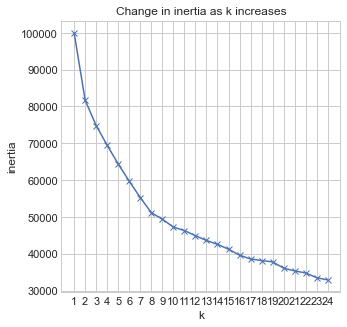

In [26]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    pd.Series({k: KMeans(k).fit(x1).inertia_ for k in range(1, 25)}).plot(marker='x')
    plt.xticks(range(1, 25))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* k = 8

In [27]:
kmeans1 = KMeans(n_clusters=8)
kmeans1.fit(x1)

cluster_basic_info = kmeans1.predict(x1)
x_train_imputed_scaled_with_dummy['claster_basic_info'] = cluster_basic_info

In [28]:
x_train_imputed_scaled_with_dummy.head()

,unit_id_institution,title_IV_eligibility,pred_degree,pred_degree_0and4,major_code,branch_number,full_time_net_tuition_revenue,off_campus_cost_of_attendace,on_campus_cost_of_attendace,admission_rate,graduate_number,ACT_score_mid,avg_sat_admitted,required_score,avg_faculty_salary,comp_rt_ft_150over_expected_time,comp_rt_ft_150over_expected_time_two_races,comp_rt_ft_150over_expected_time_native_american,comp_rt_ft_150over_expected_time_asian,comp_rt_ft_150over_expected_time_black,comp_rt_ft_150over_expected_time_hispanic,comp_rt_ft_150over_expected_time_non_resident,comp_rt_ft_150over_expected_time_unknown_race,comp_rt_ft_150over_expected_time_white,share_entering_students_first_ft,share_of_part_time,first_time_ft_student_retention,first_time_pt_student_retention,enrollment_share_two_races,enrollment_share_native_american,enrollment_share_asian,enrollment_share_black,enrollment_share_hispanic,enrollment_share_pac_islander,enrollment_share_non_resident,enrollment_share_unknown,enrollment_share_white,undergraduate_number_pell_grant_fedral_loan,med_debt_pell_students,median_debt_completed,median_debt_non_first_generation,median_debt_non_pell,fedral_loan_full_time_first_time_undergraduate,pell_grant_full_time_first_time_undergraduate,deg_percent_awarded_agriculture_operations,deg_percent_awarded_natural_resources,deg_percent_awarded_architecture,deg_percent_awarded_area_ethnic_cultural_gender,deg_percent_awarded_communication_journalism,deg_percent_awarded_communication_tech,deg_percent_awarded_computer_science,deg_percent_awarded_personal_culinary_services,deg_percent_awarded_education,deg_percent_awarded_engineering,deg_percent_awarded_engineering_tech,deg_percent_awarded_foreign_language_literatures,deg_percent_awarded_human_science,deg_percent_awarded_legal_profession,deg_percent_awarded_english_lang,deg_percent_awarded_general_studies,deg_percent_awarded_library_sciences,deg_percent_awarded_bio_sciences,deg_percent_awarded_mathematics,deg_percent_awarded_military_tech,deg_percent_awarded_intedisciplinary_studies,deg_percent_awarded_leisure_fitness,deg_percent_awarded_philosophy,deg_percent_awarded_theology,deg_percent_awarded_physical_sciences,deg_percent_awarded_science_tech,deg_percent_awarded_psychology,deg_percent_awarded_homeland_security,deg_percent_awarded_public_admin,deg_percent_awarded_social_sciences,deg_percent_awarded_construction_trades,deg_percent_awarded_mechanic_repair,deg_percent_awarded_precision_production,deg_percent_awarded_transportation_materials,deg_percent_awarded_visual_and_performing_arts,deg_percent_awarded_health,deg_percent_awarded_business_management,deg_percent_awarded_history,non_deg_seeking,income_0_30000,income_30001_48000,income_48001_75000,income_75001_110000,income_over_110000,AK,AL,AR,AS,AZ,CA,CO,CT,DC,DE,FL,FM,GA,GU,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MH,MI,MN,MO,MP,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,PR,RI,SC,SD,TN,TX,UT,VA,VI,VT,WA,WI,WV,WY,midwest,northeast,southeast,southwest,territory,west,"Private, for-profit","Private, nonprofit",Public,claster_basic_info
25656,0.371697,0.0,0.0,0.0,0.316919,1.0,0.240953,0.067287,0.230631,0.807361,0.091174,0.392256,0.386106,0.407498,0.000000,0.000000,0.058715,0.115180,0.000000,0.000000,0.000000,0.245841,0.107591,0.000000,0.000000,1.000000,0.000000,0.331473,0.631478,0.323529,0.077678,0.346300,0.038048,0.28,0.000000,0.074813,0.961952,0.482688,0.525499,0.533990,0.431971,0.327000,0.538322,0.829635,0.102941,0.000000,0.0,0.000000,0.160434,1.0,0.995810,0.0,0.094068,0.034354,0.518519,0.303922,1.0,1.000000,0.000000,0.103553,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.028332,0.345367,0.000000,0.000000,0.0,0.0,0.0,0.0,0.051745,1.000000,0.836859,0.000000,0.251560,0.331481,0.242215,0.200680,0.167286,0.053279,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2
28625,0.807654,0.0,0.0,0.0,0.708679,0.0,0.752373,0.188402,0.602648,0.590918,0.153873,0.333

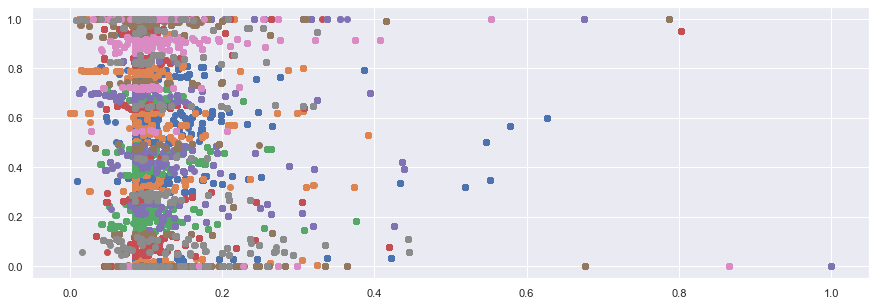

In [29]:
plt.figure(figsize=(15, 5))

for cluster_n in x_train_imputed_scaled_with_dummy.claster_basic_info.sort_values().unique():
    plt.scatter(x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.claster_basic_info == 
                                          cluster_n].graduate_number, 
                x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.claster_basic_info == cluster_n].
                unit_id_institution, label=f'cluster_{cluster_n}')

## cluster 2. all about major

In [ ]:
'major_code','ACT_score_mid','avg_sat_admitted','required_score','deg_percent_awarded_agriculture_operations',
 'deg_percent_awarded_natural_resources',
 'deg_percent_awarded_architecture',
 'deg_percent_awarded_area_ethnic_cultural_gender',
 'deg_percent_awarded_communication_journalism',
 'deg_percent_awarded_communication_tech',
 'deg_percent_awarded_computer_science',
 'deg_percent_awarded_personal_culinary_services',
 'deg_percent_awarded_education',
 'deg_percent_awarded_engineering',
 'deg_percent_awarded_engineering_tech',
 'deg_percent_awarded_foreign_language_literatures',
 'deg_percent_awarded_human_science',
 'deg_percent_awarded_legal_profession',
 'deg_percent_awarded_english_lang',
 'deg_percent_awarded_general_studies',
 'deg_percent_awarded_library_sciences',
 'deg_percent_awarded_bio_sciences',
 'deg_percent_awarded_mathematics',
 'deg_percent_awarded_military_tech',
 'deg_percent_awarded_intedisciplinary_studies',
 'deg_percent_awarded_leisure_fitness',
 'deg_percent_awarded_philosophy',
 'deg_percent_awarded_theology',
 'deg_percent_awarded_physical_sciences',
 'deg_percent_awarded_science_tech',
 'deg_percent_awarded_psychology',
 'deg_percent_awarded_homeland_security',
 'deg_percent_awarded_public_admin',
 'deg_percent_awarded_social_sciences',
 'deg_percent_awarded_construction_trades',
 'deg_percent_awarded_mechanic_repair',
 'deg_percent_awarded_precision_production',
 'deg_percent_awarded_transportation_materials',
 'deg_percent_awarded_visual_and_performing_arts',
 'deg_percent_awarded_health',
 'deg_percent_awarded_business_management',
 'deg_percent_awarded_history',
 'non_deg_seeking',

In [30]:
x2 = x_train_imputed_scaled_with_dummy[['major_code','ACT_score_mid','avg_sat_admitted','required_score',
                                        'deg_percent_awarded_agriculture_operations',
                                        'deg_percent_awarded_natural_resources','deg_percent_awarded_architecture',
                                        'deg_percent_awarded_area_ethnic_cultural_gender','deg_percent_awarded_communication_journalism',
                                        'deg_percent_awarded_communication_tech','deg_percent_awarded_computer_science',
                                        'deg_percent_awarded_personal_culinary_services',
                                        'deg_percent_awarded_education','deg_percent_awarded_engineering',
                                        'deg_percent_awarded_engineering_tech','deg_percent_awarded_foreign_language_literatures',
                                        'deg_percent_awarded_human_science','deg_percent_awarded_legal_profession',
                                        'deg_percent_awarded_english_lang','deg_percent_awarded_general_studies',
                                        'deg_percent_awarded_library_sciences','deg_percent_awarded_bio_sciences',
                                        'deg_percent_awarded_mathematics','deg_percent_awarded_military_tech',
                                        'deg_percent_awarded_intedisciplinary_studies','deg_percent_awarded_leisure_fitness',
                                        'deg_percent_awarded_philosophy','deg_percent_awarded_theology',
                                        'deg_percent_awarded_physical_sciences','deg_percent_awarded_science_tech',
                                        'deg_percent_awarded_psychology','deg_percent_awarded_homeland_security',
                                        'deg_percent_awarded_public_admin','deg_percent_awarded_social_sciences',
                                        'deg_percent_awarded_construction_trades','deg_percent_awarded_mechanic_repair',
                                        'deg_percent_awarded_precision_production','deg_percent_awarded_transportation_materials',
                                        'deg_percent_awarded_visual_and_performing_arts','deg_percent_awarded_health',
                                        'deg_percent_awarded_business_management','deg_percent_awarded_history',
                                        'non_deg_seeking']]

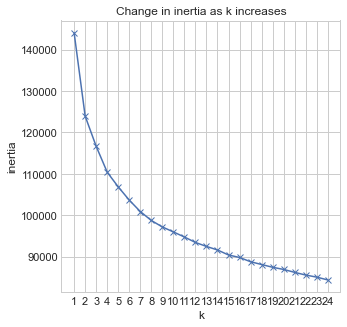

In [31]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    pd.Series({k: KMeans(k).fit(x2).inertia_ for k in range(1, 25)}).plot(marker='x')
    plt.xticks(range(1, 25))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* k = 7

In [32]:
kmeans2 = KMeans(n_clusters=7)
kmeans2.fit(x2)

cluster_major = kmeans2.predict(x2)
x_train_imputed_scaled_with_dummy['claster_major'] = cluster_major

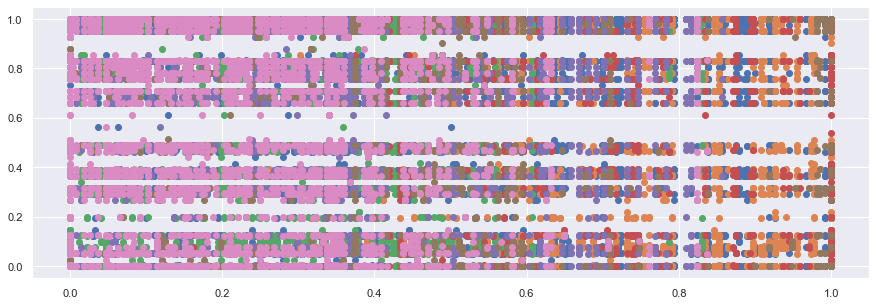

In [33]:
plt.figure(figsize=(15, 5))

for cluster_n in x_train_imputed_scaled_with_dummy.claster_major.sort_values().unique():
    plt.scatter(x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.claster_major == cluster_n].
                avg_sat_admitted, 
                x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.claster_major == cluster_n].
                major_code, label=f'cluster_{cluster_n}')

## cluster 3. cost

In [ ]:
'off_campus_cost_of_attendace','on_campus_cost_of_attendace',
'undergraduate_number_pell_grant_fedral_loan',
 'med_debt_pell_students',
 'median_debt_completed',
 'median_debt_non_first_generation',
 'median_debt_non_pell',
 'fedral_loan_full_time_first_time_undergraduate',
 'pell_grant_full_time_first_time_undergraduate',

In [34]:
x3 = x_train_imputed_scaled_with_dummy[['off_campus_cost_of_attendace','on_campus_cost_of_attendace',
                                        'undergraduate_number_pell_grant_fedral_loan','med_debt_pell_students',
                                        'median_debt_completed','median_debt_non_first_generation','median_debt_non_pell',
                                        'fedral_loan_full_time_first_time_undergraduate','pell_grant_full_time_first_time_undergraduate']]

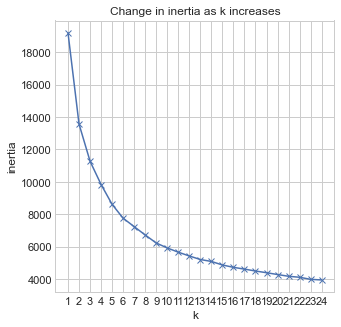

In [35]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    pd.Series({k: KMeans(k).fit(x3).inertia_ for k in range(1, 25)}).plot(marker='x')
    plt.xticks(range(1, 25))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* k = 6

In [36]:
kmeans3 = KMeans(n_clusters=6)
kmeans3.fit(x3)

cluster_cost = kmeans3.predict(x3)
x_train_imputed_scaled_with_dummy['claster_cost'] = cluster_cost

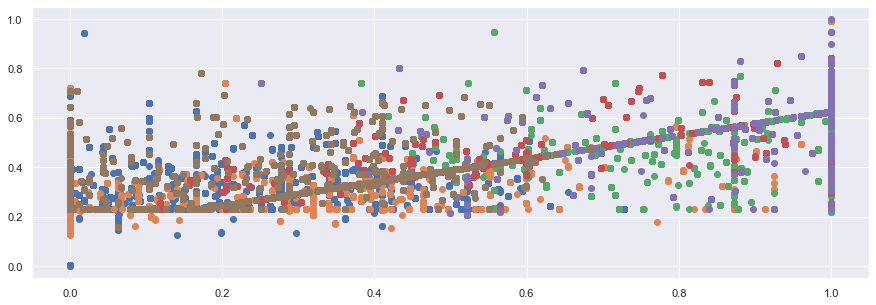

In [41]:
plt.figure(figsize=(15, 5))

for cluster_n in x_train_imputed_scaled_with_dummy.claster_cost.sort_values().unique():
    plt.scatter(x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.claster_cost == cluster_n].
                off_campus_cost_of_attendace, 
                x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.claster_cost == cluster_n].
                on_campus_cost_of_attendace, label=f'cluster_{cluster_n}')

## cluster 4. student income

In [ ]:
'income_0_30000',
 'income_30001_48000',
 'income_48001_75000',
 'income_75001_110000',
 'income_over_110000'

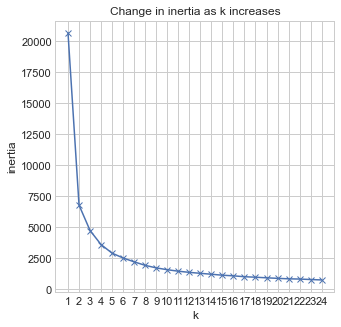

In [43]:
x4 = x_train_imputed_scaled_with_dummy[['income_0_30000','income_30001_48000','income_48001_75000',
                                        'income_75001_110000','income_over_110000']]
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    pd.Series({k: KMeans(k).fit(x4).inertia_ for k in range(1, 25)}).plot(marker='x')
    plt.xticks(range(1, 25))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

## cluster 5. student info

In [ ]:
'comp_rt_ft_150over_expected_time',
 'comp_rt_ft_150over_expected_time_two_races',
 'comp_rt_ft_150over_expected_time_native_american',
 'comp_rt_ft_150over_expected_time_asian',
 'comp_rt_ft_150over_expected_time_black',
 'comp_rt_ft_150over_expected_time_hispanic',
 'comp_rt_ft_150over_expected_time_non_resident',
 'comp_rt_ft_150over_expected_time_unknown_race',
 'comp_rt_ft_150over_expected_time_white',
'share_entering_students_first_ft',
 'share_of_part_time',
 'first_time_ft_student_retention',
 'first_time_pt_student_retention',
 'enrollment_share_two_races',
 'enrollment_share_native_american',
 'enrollment_share_asian',
 'enrollment_share_black',
 'enrollment_share_hispanic',
 'enrollment_share_pac_islander',
 'enrollment_share_non_resident',
 'enrollment_share_unknown',
 'enrollment_share_white'

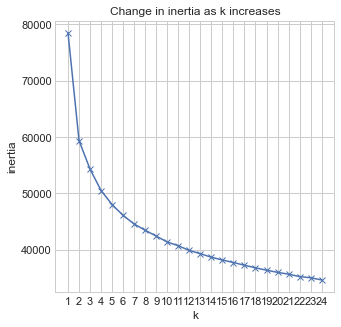

In [44]:
x5 = x_train_imputed_scaled_with_dummy[['comp_rt_ft_150over_expected_time','comp_rt_ft_150over_expected_time_two_races',
                                        'comp_rt_ft_150over_expected_time_native_american','comp_rt_ft_150over_expected_time_asian',
                                        'comp_rt_ft_150over_expected_time_black','comp_rt_ft_150over_expected_time_hispanic',
                                        'comp_rt_ft_150over_expected_time_non_resident','comp_rt_ft_150over_expected_time_unknown_race',
                                        'comp_rt_ft_150over_expected_time_white','share_entering_students_first_ft',
                                        'share_of_part_time','first_time_ft_student_retention','first_time_pt_student_retention',
                                        'enrollment_share_two_races','enrollment_share_native_american',
                                        'enrollment_share_asian','enrollment_share_black','enrollment_share_hispanic',
                                        'enrollment_share_pac_islander','enrollment_share_non_resident',
                                        'enrollment_share_unknown','enrollment_share_white']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(5, 5))
    pd.Series({k: KMeans(k).fit(x5).inertia_ for k in range(1, 25)}).plot(marker='x')
    plt.xticks(range(1, 25))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

* k = 5

In [45]:
kmeans5 = KMeans(n_clusters=5)
kmeans5.fit(x5)

cluster_student = kmeans5.predict(x5)
x_train_imputed_scaled_with_dummy['claster_student'] = cluster_student

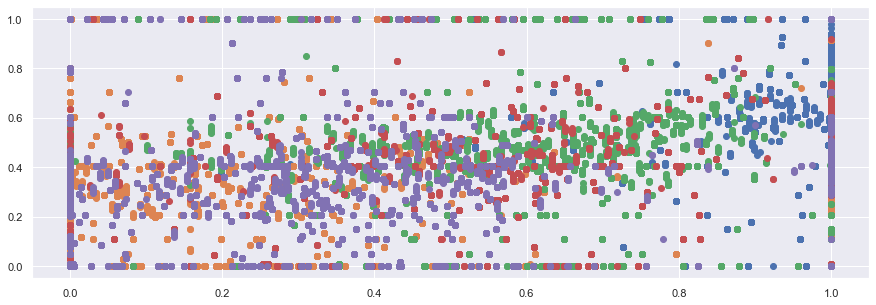

In [46]:
plt.figure(figsize=(15, 5))

for cluster_n in x_train_imputed_scaled_with_dummy.claster_student.sort_values().unique():
    plt.scatter(x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.claster_student == cluster_n].
                first_time_ft_student_retention, 
                x_train_imputed_scaled_with_dummy[x_train_imputed_scaled_with_dummy.claster_student == cluster_n].
                first_time_pt_student_retention,label=f'cluster_{cluster_n}')

## Feature Engineering

In [47]:
x_train_imputed_scaled_with_dummy = pd.get_dummies(x_train_imputed_scaled_with_dummy, columns=['claster_basic_info'])
x_train_imputed_scaled_with_dummy = pd.get_dummies(x_train_imputed_scaled_with_dummy, columns=['claster_major'])
x_train_imputed_scaled_with_dummy = pd.get_dummies(x_train_imputed_scaled_with_dummy, columns=['claster_cost'])
x_train_imputed_scaled_with_dummy = pd.get_dummies(x_train_imputed_scaled_with_dummy, columns=['claster_student'])

1. select k best

In [55]:
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

kbest = SelectKBest(f_regression, k=30)
kbest.fit(x_train_imputed_scaled_with_dummy, y_train_imputed)

kbest_results = pd.DataFrame(dict(p=kbest.pvalues_, f=kbest.scores_), index=x_train_imputed_scaled_with_dummy.columns)
kbest_results.head(10)

,p,f
unit_id_institution,3.374173e-36,158.155257
title_IV_eligibility,1.000000e+00,0.000000
pred_degree,1.000000e+00,0.000000
pred_degree_0and4,1.000000e+00,0.000000
major_code,1.306122e-01,2.285310
branch_number,1.170044e-127,582.105813
full_time_net_tuition_revenue,0.000000e+00,4862.888212
off_campus_cost_of_attendace,4.309361e-60,268.277809
on_campus_cost_of_attendace,0.000000e+00,1620.893689
admission_rate,8.600764e-19,78.437975


In [56]:
x_train_imputed_scaled_with_dummy.columns[kbest.get_support()]

Index(['full_time_net_tuition_revenue', 'on_campus_cost_of_attendace',
       'comp_rt_ft_150over_expected_time',
       'comp_rt_ft_150over_expected_time_two_races',
       'comp_rt_ft_150over_expected_time_non_resident',
       'comp_rt_ft_150over_expected_time_white',
       'share_entering_students_first_ft', 'share_of_part_time',
       'enrollment_share_white', 'undergraduate_number_pell_grant_fedral_loan',
       'med_debt_pell_students', 'median_debt_completed',
       'median_debt_non_first_generation', 'median_debt_non_pell',
       'pell_grant_full_time_first_time_undergraduate',
       'deg_percent_awarded_engineering_tech',
       'deg_percent_awarded_english_lang', 'deg_percent_awarded_bio_sciences',
       'deg_percent_awarded_philosophy',
       'deg_percent_awarded_homeland_security',
       'deg_percent_awarded_visual_and_performing_arts', 'non_deg_seeking',
       'income_0_30000', 'Private, nonprofit', 'Public',
       'claster_basic_info_0', 'claster_basic_info_4',

2. Recursive Feature Elimination (RFE)

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

lm = LinearRegression()

rfe = RFE(lm, n_features_to_select=30)

rfe.fit(x_train_imputed_scaled_with_dummy,y_train_imputed)  

feature_mask = rfe.support_

rfe_feature = x_train_imputed_scaled_with_dummy.iloc[:,feature_mask].columns.tolist()
rfe_feature

['AS',
 'FM',
 'GU',
 'MN',
 'MP',
 'OH',
 'PR',
 'SD',
 'VI',
 'midwest',
 'northeast',
 'southeast',
 'claster_basic_info_0',
 'claster_basic_info_1',
 'claster_basic_info_2',
 'claster_basic_info_3',
 'claster_basic_info_4',
 'claster_basic_info_7',
 'claster_major_0',
 'claster_major_1',
 'claster_major_2',
 'claster_major_3',
 'claster_major_4',
 'claster_major_5',
 'claster_major_6',
 'claster_student_0',
 'claster_student_1',
 'claster_student_2',
 'claster_student_3',
 'claster_student_4']

# Modeling

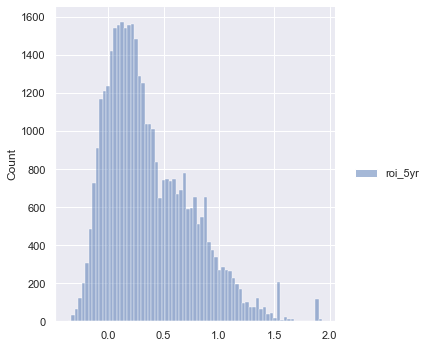

In [58]:
# Visualize target variable
sns.displot(y_train_imputed)

### Baseline

In [62]:
#Establish baselines for the train and validation subsets
baseline = train_imputed.roi_5yr.mean()

train_imputed['baseline'] = baseline
validate_imputed['baseline'] = baseline

train_rmse = sqrt(mean_squared_error(train_imputed.roi_5yr, train_imputed.baseline))
validate_rmse = sqrt(mean_squared_error(validate_imputed.roi_5yr, validate_imputed.baseline))

print('Train baseline RMSE: {}.'.format(train_rmse))
print('Validation baseline RMSE: {}.'.format(validate_rmse))

Train baseline RMSE: 0.38174842144612947.
Validation baseline RMSE: 0.38033342886322746.
